In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.stats import multivariate_normal as norm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [36]:
def create_complete_datasets(data_dict):
    '''
    Function for creating complete training and test sets containing
    all classes.
    '''
    #Empty list
    trainset = []
    traintargets =[]
    testset = []
    testtargets =[]
    
    #For each class
    for i in range(10):
        trainset.append(data_dict["train%d"%i])
        traintargets.append(np.full(len(data_dict["train%d"%i]),i))
        testset.append(data_dict["test%d"%i])
        testtargets.append(np.full(len(data_dict["test%d"%i]),i))
    
    #Concatenate into to complete datasets
    trainset = np.concatenate(trainset)
    traintargets = np.concatenate(traintargets)
    testset = np.concatenate(testset)
    testtargets = np.concatenate(testtargets)
    return trainset, traintargets, testset, testtargets

file = "data/mnist_all.mat"
data = loadmat(file)

#Complete training and test sets
train_set, train_targets, test_set, test_targets = create_complete_datasets(data)
classes = np.unique(train_targets)
num_classes = len(classes)

In [32]:
n_components = 9

#PCA
PCA_model = PCA(n_components=n_components)
PCA_model.fit(train_set)
PCA_train = PCA_model.transform(train_set)

#LDA
LDA_model = LDA(n_components=n_components)
LDA_model.fit(train_set,train_targets)
LDA_train = LDA_model.transform(train_set)


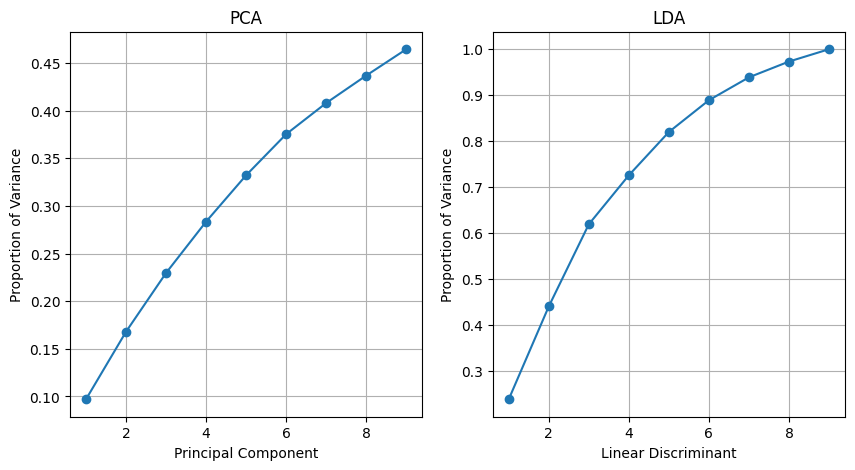

In [33]:
# Analyze proportion of Variance. If num_components=2 try to visualize dim. reduced data.
PC_values = np.arange(1,n_components+1)

plt.figure(figsize=(10,5))
#PCA
plt.subplot(1,2,1)
plt.plot(PC_values, np.cumsum(PCA_model.explained_variance_ratio_), marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance")
plt.title("PCA")
plt.grid()
#LDA
plt.subplot(1,2,2)
plt.plot(PC_values,np.cumsum(LDA_model.explained_variance_ratio_), marker="o")
plt.xlabel("Linear Discriminant")
plt.ylabel("Proportion of Variance")
plt.title("LDA")
plt.grid()
plt.show()


Plotting the cumulative sum of the explained variance shows that even with 9 components the PCA only reaches about 50% explained variance. Following the rule of stopping around 90% this means that the PCA would need significantly more components to represent the data.

The LDA reaches 100% explained variance at 9 components. This one could probably even be reduced to have 6 components, as this is just about 90% explained variance.

In [34]:
def likelihood(data, mean, cov):
    likelihood_value = norm(mean=mean, cov=cov).pdf(data)
    return likelihood_value

# Estimate Gaussians from PCA/LDA

#PCA
PCA_means = np.zeros((num_classes, n_components))
PCA_covs = np.zeros((num_classes, n_components,n_components))

for i in range(num_classes):
    # Estimate mean and covariance for each class using PCA-transformed train data
    PCA_means[i] = np.mean(PCA_train[train_targets==classes[i]], axis=0)
    PCA_covs[i] = np.cov(PCA_train[train_targets==classes[i]].T)
    
#PCA
LDA_means = np.zeros((num_classes, n_components))
LDA_covs = np.zeros((num_classes, n_components,n_components))

for i in range(num_classes):
    # Estimate mean and covariance for each class using PCA-transformed train data
    LDA_means[i] = np.mean(LDA_train[train_targets==classes[i]], axis=0)
    LDA_covs[i] = np.cov(LDA_train[train_targets==classes[i]].T)

In [39]:
#Compute predictions

#PCA
PCA_test = PCA_model.transform(test_set)
PCA_priors = np.zeros(num_classes)
PCA_likelihoods = np.zeros((len(PCA_test),num_classes))
PCA_posteriors = np.zeros((len(PCA_test),num_classes))

#LDA
LDA_test = LDA_model.transform(test_set)
LDA_priors = np.zeros(num_classes)
LDA_likelihoods = np.zeros((len(LDA_test),num_classes))
LDA_posteriors = np.zeros((len(LDA_test),num_classes))

for i in range(num_classes):
    # Compute priors
    PCA_priors[i] = np.sum(train_targets==classes[i])/len(train_targets)
    # Compute Likelihoods
    PCA_likelihoods[:,i] = likelihood(PCA_test, PCA_means[i], PCA_covs[i])
    # Compute posteriors
    PCA_posteriors[:,i] = PCA_priors[i]*PCA_likelihoods[:,i]
    
    # Compute priors
    LDA_priors[i] = np.sum(train_targets==classes[i])/len(train_targets)
    # Compute Likelihoods
    LDA_likelihoods[:,i] = likelihood(LDA_test, LDA_means[i], LDA_covs[i])
    # Compute posteriors
    LDA_posteriors[:,i] = LDA_priors[i]*LDA_likelihoods[:,i]

# argmax across classes
PCA_predictions = classes[np.argmax(PCA_posteriors, axis=1)]
LDA_predictions = classes[np.argmax(LDA_posteriors, axis=1)]

#Compute accuracy
accuracy_PCA = np.sum(PCA_predictions==test_targets)/len(test_targets)
accuracy_LDA = np.sum(LDA_predictions==test_targets)/len(test_targets)
print(f'PCA accuracy: {accuracy_PCA}')
print(f'LDA accuracy: {accuracy_LDA}')


PCA accuracy: 0.8775
LDA accuracy: 0.8953


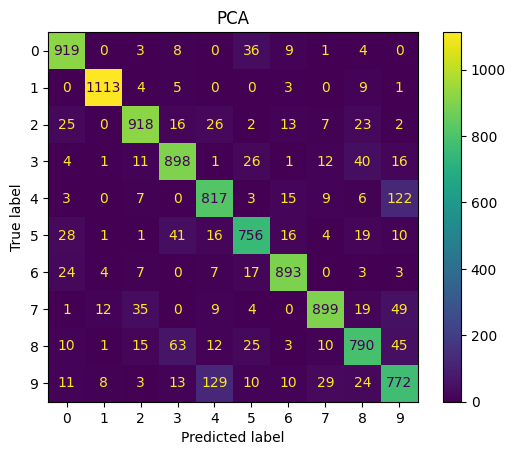

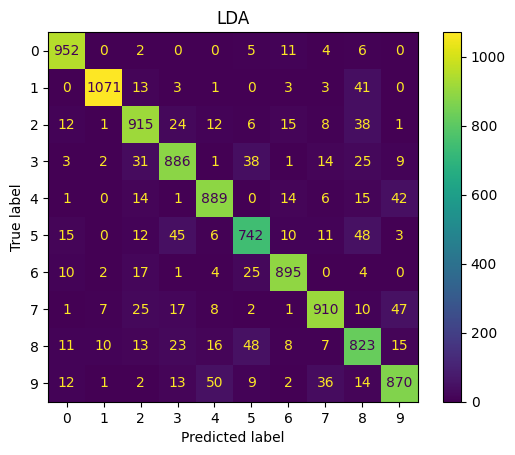

In [46]:
#Compute the confusion matrices for PCA and LDA
PCA_confusion = confusion_matrix(test_targets, PCA_predictions)
LDA_confusion = confusion_matrix(test_targets, LDA_predictions)


#Plot Confusion matrices
PCA_plot = ConfusionMatrixDisplay(PCA_confusion, display_labels=classes)
LDA_plot = ConfusionMatrixDisplay(LDA_confusion, display_labels=classes)

PCA_plot.plot()
plt.title("PCA")
LDA_plot.plot()
plt.title("LDA")
plt.show()